# Compresión de imágenes RGB

In [2]:
import pkg_resources
import subprocess

def check_packages(package_list):
    for package_name in package_list:
        try:
            pkg_resources.get_distribution(package_name)
        except pkg_resources.DistributionNotFound:
            print(f"{package_name} no está instalado. Instalando...")
            subprocess.check_call(["pip", "install", package_name])
            print(f"{package_name} ha sido instalado correctamente.")

# packages_to_check = ['scikit-image', 'scipy', 'opencv-python']
# check_packages(packages_to_check)

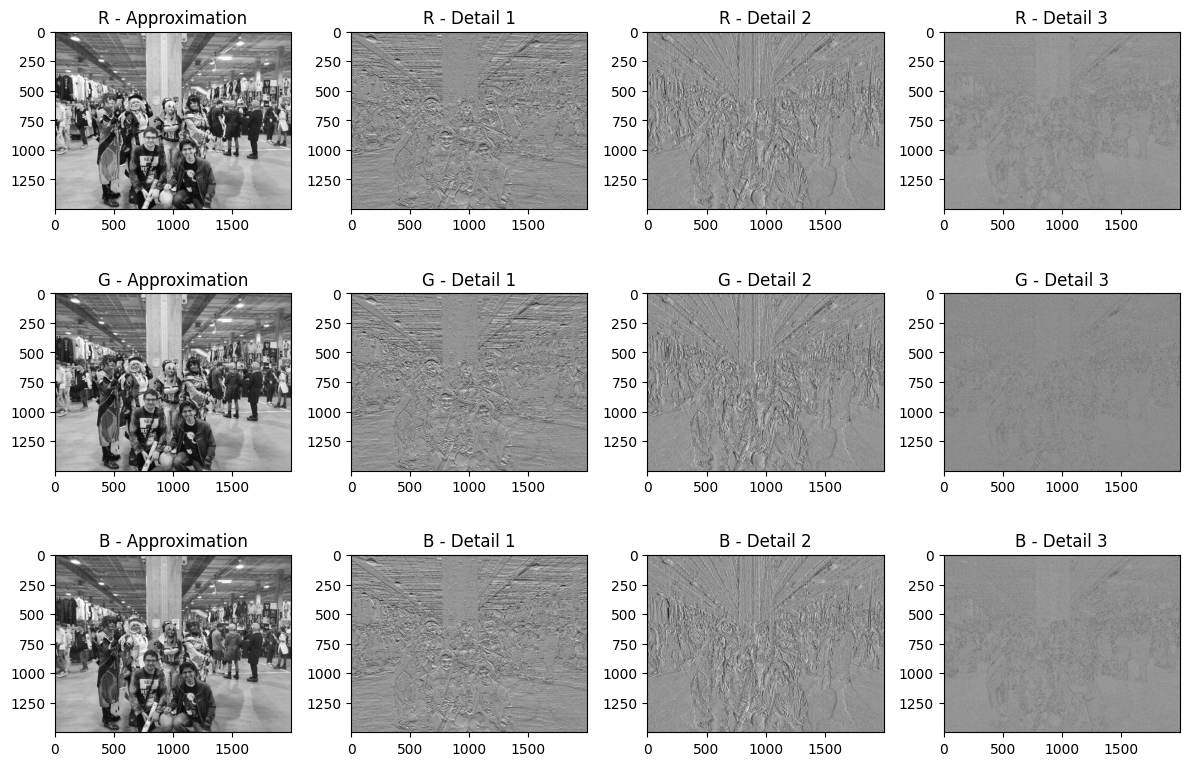

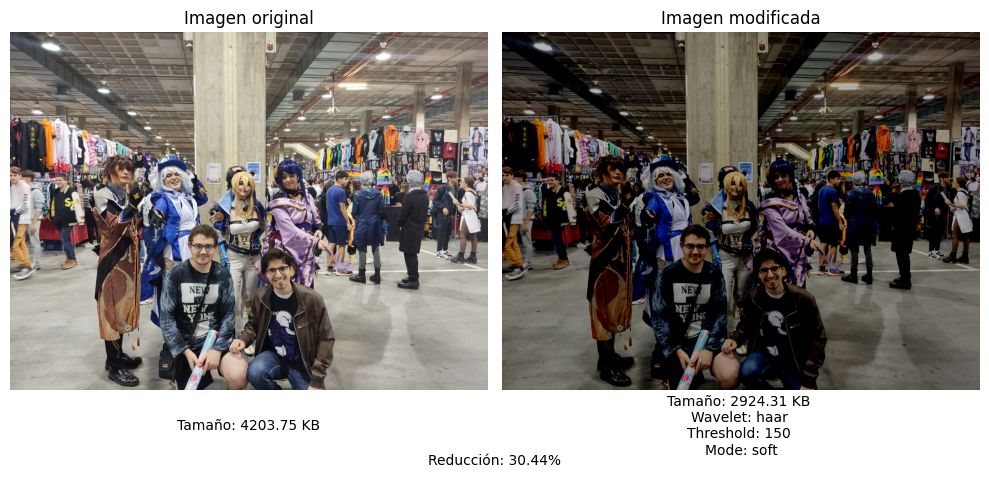

In [28]:
# Comprobación de paquetes
packages = ['scikit-image', 'scipy', 'opencv-python', 'numpy']
check_packages(packages)

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pywt
from PIL import Image
from skimage import exposure 
from scipy import ndimage
import os

def compress_image(image_path, wavelet = 'haar', threshold = 250, substitute = 0, orientation = "vertical", mode = "garrote", value_low = 50, value_high = 250, plot = True, save = True):
    # Carga de la imagen RGB
    img = Image.open(image_path)
    img_array = np.array(img)
    
    if orientation == 'vertical':
        img_array = np.fliplr(np.transpose(img_array, (1, 0, 2)))  # Transponer para imágenes verticales
    else:
        img_array = img_array  # No transponer (imágenes horizontales)
    
    # Separar canales RGB de la imagen
    r, g, b = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2]

    # Aplicar wavelet en cada canal y hallar coeficientes
    def apply_wavelet(channel, wavelet):
        coeffs = pywt.dwt2(channel, wavelet)
        cA, (cH, cV, cD) = coeffs
        return cA, cH, cV, cD

    # Coeficientes R, G y B
    r_coeffs = apply_wavelet(r, wavelet)
    g_coeffs = apply_wavelet(g, wavelet)
    b_coeffs = apply_wavelet(b, wavelet)
    
    # Ver gráfico de aproximación y detalles
    
    if plot:
        fig, axs = plt.subplots(3, 4, figsize = (12, 8))

        for i, coeffs in enumerate([r_coeffs, g_coeffs, b_coeffs]):

            axs[i, 0].imshow(coeffs[0], cmap = "gray")
            axs[i, 0].set_title(f'{["R", "G", "B"][i]} - Approximation')

    # Contraste mejorado con exposusure.equalize_hist
    
            for j, coeff in enumerate(coeffs[1:]):
                equalized_coeff = exposure.equalize_hist(coeff)
        
                axs[i, j+1].imshow(equalized_coeff, cmap='gray')
                axs[i, j+1].set_title(f'{["R", "G", "B"][i]} - Detail {j+1}')

        plt.tight_layout()
        plt.show()

    # Meter threshold en coeficientes para la compresión
    if mode == 'firm':
        r_coeffs_compressed = [pywt.threshold_firm(i, value_low = value_low, value_high = value_high) for i in r_coeffs]
        g_coeffs_compressed = [pywt.threshold_firm(i, value_low = value_low, value_high = value_high) for i in g_coeffs]
        b_coeffs_compressed = [pywt.threshold_firm(i, value_low = value_low, value_high = value_high) for i in b_coeffs]
    else:
        r_coeffs_compressed = [pywt.threshold(i, value=threshold, substitute = substitute, mode=mode) for i in r_coeffs]
        g_coeffs_compressed = [pywt.threshold(i, value=threshold, substitute = substitute, mode=mode) for i in g_coeffs]
        b_coeffs_compressed = [pywt.threshold(i, value=threshold, substitute = substitute, mode=mode) for i in b_coeffs]

    # Reconstrucción de canales tras la compresión
    def reconstruct_channel(cA, cH, cV, cD, wavelet_type):
        coeffs = (cA, (cH, cV, cD))
        reconstructed_channel = pywt.idwt2(coeffs, wavelet_type)
        return reconstructed_channel

    reconstructed_r = reconstruct_channel(*r_coeffs_compressed, wavelet)
    reconstructed_g = reconstruct_channel(*g_coeffs_compressed, wavelet)
    reconstructed_b = reconstruct_channel(*b_coeffs_compressed, wavelet)

    # Reconstrucción de la imagen a partir de los canales
    reconstructed_image = np.stack((reconstructed_r, reconstructed_g, reconstructed_b), axis=-1)
    reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8) / 255.0
    
    # Ruta de guardado
    output_image_path = os.path.splitext(image_path)[0]
    original_extension = os.path.splitext(image_path)[1]
    output_image_path = f"{output_image_path}_{wavelet}_{mode}_{threshold}{original_extension}"
    
    # Guardado de la imagen reconstruida
    reconstructed_image_uint8 = np.clip(reconstructed_image * 255, 0, 255).astype(np.uint8)
    bgr_image = cv2.cvtColor(reconstructed_image_uint8, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_image_path, bgr_image) # necesita rango entre 0 y 255
    
    # Tamaños de imágenes original y reconstruida con su reducción
    original_size = os.path.getsize(image_path) / 1024  # tamaño inicial en KB de la imagen
    reconstructed_size = os.path.getsize(output_image_path) / 1024  # tamaño final en KB de la imagen
    reduction_percentage = ((original_size - reconstructed_size) / original_size) * 100 # reducción de tamaño en porcentaje
    
    if not save:
        os.remove(output_image_path) # útil por si no queremos acumular imágenes y solo queremos el tamaño
    
    # Figura en sí
    if plot:
        
        fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

        axes[0].imshow(img_array)
        axes[0].set_title(f'Imagen original')
        axes[0].axis('off')
        axes[0].annotate(f'Tamaño: {original_size:.2f} KB', xy = (0.5, -0.1), xycoords="axes fraction", ha='center', va='center')

    
        axes[1].imshow(reconstructed_image_uint8)
        axes[1].set_title(f'Imagen modificada')
        axes[1].axis('off')
        axes[1].annotate(f'Tamaño: {reconstructed_size:.2f} KB \nWavelet: {wavelet} \nThreshold: {threshold} \nMode: {mode}', xy=(0.5, -0.1), xycoords="axes fraction", ha='center', va='center')
    
        reduction_text = f'Reducción: {reduction_percentage:.2f}%'
        plt.figtext(0.5, 0, reduction_text, ha = 'center', va = 'center')

        plt.tight_layout()
        plt.show()

    return output_image_path, reduction_percentage, reconstructed_image

# Uso de la función con valores por defecto
output_image_path, reduction_percentage, reconstructed = compress_image(image_path = './data/genshin.jpg', wavelet = 'haar', threshold = 150, substitute = 0, orientation = "horizontal", mode = "soft", value_low = 50, value_high = 250, plot = True, save = False)



# Información acerca de cómo funcionan los distintos modos de pywt.threshold

## Modes

Entrada: array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ])   

### Soft thresholding.

Establece en cero (o el valor colocado en *substitute*) los coeficientes cuya magnitud sea menor que el valor umbral (value), reduciendo además el resto de determinada manera.

**Ejemplo:**  
pywt.threshold(data, 2, 'soft')  
Salida: array([ 0. ,  0. ,  0. ,  0.5,  1. ,  1.5,  2. ])  

Estrictamente: data/np.abs(data) * np.maximum(np.abs(data) - value, 0).

### Hard thresholding.

Establece en cero (o el valor colocado en *substitute*) los coeficientes cuya magnitud sea menor que el umbral, manteniendo intactos los otros.  

**Ejemplo:**  
pywt.threshold(data, 2, 'hard')  
array([ 0. ,  0. ,  2. ,  2.5,  3. ,  3.5,  4. ])

### Greater or less thresholding.

Establecen en cero (o el valor colocado en *substitute*) los coeficientes cuya magnitud sea mayor o menor que el valor umbral, respectivamente.  

**Ejemplo:**  
pywt.threshold(data, 2, 'greater')  
array([ 0. ,  0. ,  2. ,  2.5,  3. ,  3.5,  4. ])  

pywt.threshold(data, 2, 'less')  
array([ 1. ,  1.5,  2. ,  0. ,  0. ,  0. ,  0. ])  

### Garrote thresholding.

Se comporta de manera intermedia a *hard* y *soft*. Para valores pequeños es como *soft* y para valores muy grandes se aproxima cada vez más a *hard*.  

**Ejemplo:**  
pywt.threshold(data, 2, 'garrote')  
array([ 0.,  0.,  0. ,  0.9,  1.66666667, 2.35714286,  3.])  

# Código para comparación entre distintos tipos de wavelets, threshold values y modos

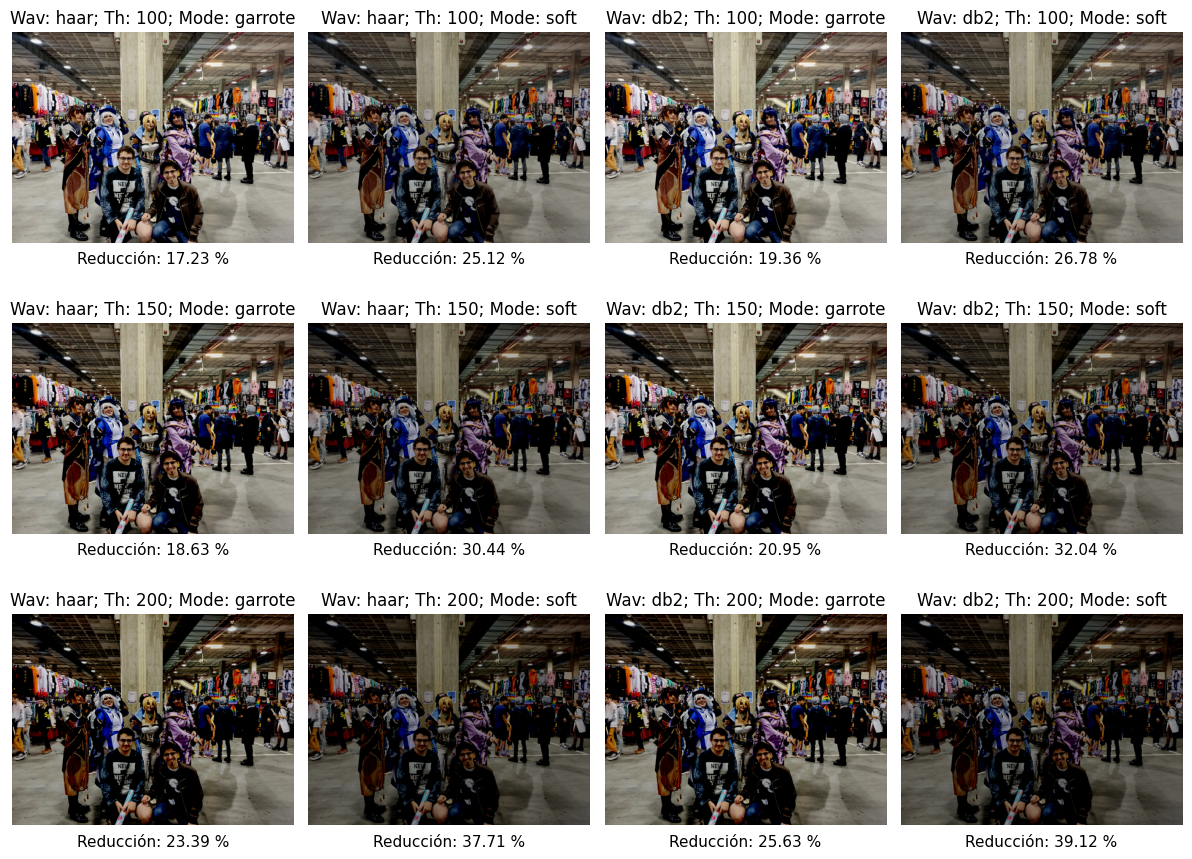

In [5]:
# Listas de parámetros a probar

wavelet_families = ['haar', 'db2']  # Ejemplo de familias de wavelets a probar
threshold_values = [100, 150, 200]  # Ejemplo de valores de threshold a probar
modes = ['garrote', 'soft']  # Ejemplo de modos a probar

num_rows = len(threshold_values)
num_cols = len(wavelet_families) * len(modes)

fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (12, 9))


for i, threshold in enumerate(threshold_values):
    for j, wavelet in enumerate(wavelet_families):
        for k, mode in enumerate(modes):
            output_image_path, reduction_percentage, reconstructed = compress_image(image_path = './data/genshin.jpg', wavelet = wavelet, threshold = threshold, mode = mode, substitute = 0, orientation = "horizontal", value_low = 50, value_high = 250, plot = False)
            col_index = j * len(modes) + k
            ax = axes[i, col_index]
            ax.imshow(reconstructed)
            ax.set_title(f'Wav: {wavelet}; Th: {threshold}; Mode: {mode}')
            ax.annotate(f'Reducción: {reduction_percentage:.2f} %', xy = (0.5, -0.1), xycoords = 'axes fraction', ha = 'center', fontsize = 11)
            ax.axis('off')

plt.tight_layout()

plt.savefig('./data/genshin_plot.jpg')
plt.show()

In [89]:
import pandas as pd

def find_optimal_threshold(image_path, target_reduction = 60, wavelet = 'haar', mode = 'garrote', max_iterations = 10, tolerance = 3, step_size = 20, orientation = "vertical", adaptative = True, initial_range = False):
    
    img = Image.open(image_path)
    original_size = os.path.getsize(image_path) / 1024  # Tamaño original en KB
    current_reduction = 0
    results = []
    
    if initial_range:
        if (target_reduction >= 65):
            threshold = 250
        elif (target_reduction >= 30 and target_reduction < 65):
            threshold = 150
        else:
            threshold = 100
    else:
        threshold = 200 # valor más o menos medio

    default_step_size = step_size
    
    for it in range(1, max_iterations + 1):
        output_image_path, _, reconstructed = compress_image(image_path, wavelet = wavelet, threshold = threshold, mode = mode, plot = False, orientation = orientation, save = True)
        reconstructed_size = os.path.getsize(output_image_path) / 1024  # Tamaño de la imagen comprimida en KB
        current_reduction = ((original_size - reconstructed_size) / original_size) * 100

        if abs(current_reduction - target_reduction) < tolerance:
            #print(f"Iteración: {it}, Reducción actual: {current_reduction:.2f} %, Umbral actual: {threshold}")
            print("Alcanzada la reducción deseada dentro del margen de tolerancia.")
            results.append([it, current_reduction, threshold])
            break  # Si se alcanza la compresión deseada dentro de la tolerancia, salir del bucle
        
        #print(f"Iteración: {it}, Reducción actual: {current_reduction:.2f} %, Umbral actual: {threshold}")
        results.append([it, current_reduction, threshold])
        
        os.remove(output_image_path)
        
        # Paso adaptatativo
        if adaptative:
            if current_reduction * 1.2 < target_reduction or current_reduction * 0.8 > target_reduction:  # Comprobar la condición adicional
                step_size *= 1.3  # Modificar step_size si se cumple la condición
            else:
                step_size = default_step_size  # Restaurar el valor predeterminado de step_size
            
        # Ajustar el umbral para la siguiente iteración
        if current_reduction < target_reduction:
            threshold += step_size
        else:
            threshold -= step_size
            
    table = pd.DataFrame(results)
    table.columns = ['Iteration', 'Reduction (%)', 'Threshold']
    
    return table, reconstructed

tabla, reconstructed = find_optimal_threshold('./data/genshin.jpg', wavelet = "haar", mode = "garrote", orientation = "horizontal", adaptative = True, initial_range = False) # adaptative = True permite reducir núm de iteraciones; initial_range establecido un poco a ojo
tabla.head(n = 10)

Alcanzada la reducción deseada dentro del margen de tolerancia.


,Iteration,Reduction (%),Threshold
0,1,23.393245,200.000
1,2,28.051800,226.000
2,3,35.531845,259.800
3,4,47.703873,303.740
4,5,65.727053,360.862
5,6,58.715642,340.862
